In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from dataset import COLORS,CityscapesPTDataset
from sklearn.metrics import confusion_matrix
import kornia.augmentation as K
import torch.utils.benchmark as benchmark


In [13]:
# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
print(f"\U0001F7E2 Using GPU: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else print("\U0001F7E1 Using CPU")

batch_size = 8
num_classes = 19
epochs = 10
resize = (256, 512)
checkpoint_path = 'deeplabv3_cityscapes_best.pth'
last_checkpoint_path = 'deeplabv3_cityscapes_last.pth'
best_val_loss = float('inf')

# 📦 Dataset & Loader
root_dir = 'datasets/realcityscapes_pt'
train_ds = CityscapesPTDataset(root=root_dir, split='train')
val_ds = CityscapesPTDataset(root=root_dir, split='val')

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# 🧠 Modello + ottimizzatore + scheduler
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)
model = model.to(memory_format=torch.channels_last)
# torch.compile rimosso per compatibilità

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
scaler = torch.cuda.amp.GradScaler()


# 🔁 Checkpoint
start_epoch = 0
checkpoint = None
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f"✅ Caricato checkpoint MIGLIORE da '{checkpoint_path}'")
elif os.path.exists(last_checkpoint_path):
    checkpoint = torch.load(last_checkpoint_path, map_location=device)
    print(f"✅ Caricato checkpoint ULTIMO da '{last_checkpoint_path}'")
else:
    print("🆕 Nessun checkpoint trovato, si parte da zero.")

if checkpoint:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scaler.load_state_dict(checkpoint['scaler'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    print(f"🔁 Ripresa da epoca {start_epoch}")

# 🎨 Kornia GPU augmentations
augmentations = torch.nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.ColorJitter(0.4, 0.4, 0.2, 0.1),
    K.RandomAffine(degrees=10, translate=(0.1, 0.1))
).to(device)

# 🧮 Funzione per mIoU
def compute_iou(preds, labels, num_classes, ignore_index=255):
    preds = preds.flatten()
    labels = labels.flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = intersection / np.maximum(union, 1)
    return iou

# 🏁 Training loop
# ✅ Nuove variabili per best model ed early stopping
best_miou = 0.0
patience = 5
epochs_no_improve = 0

for epoch in range(start_epoch, start_epoch + epochs):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch+epochs} [Train]")
    for images, masks in loop:
        images = images.to(device, memory_format=torch.channels_last, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        images = augmentations(images)

        with torch.amp.autocast(device_type='cuda'):
            out = model(images)['out']
            loss = criterion(out, masks)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(loop.n+1))

    avg_train_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

    # 📉 Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{start_epoch+epochs} [Val]"):
            images = images.to(device)
            masks = masks.to(device)
            with torch.amp.autocast(device_type='cuda'):
                out = model(images)['out']
                loss = criterion(out, masks)
            val_loss += loss.item()

            preds = torch.argmax(out, dim=1).cpu().numpy()
            gt = masks.cpu().numpy()
            all_preds.append(preds)
            all_labels.append(gt)

    avg_val_loss = val_loss / len(val_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    mean_iou = compute_iou(all_preds, all_labels, num_classes)
    miou_score = np.nanmean(mean_iou)
    scheduler.step(avg_val_loss)

    print(f"📉 Avg Val Loss = {avg_val_loss:.4f}")
    print(f"📊 mIoU = {miou_score:.4f}")

    # ✅ Controllo miglioramento mIoU
    if miou_score > best_miou:
        best_miou = miou_score
        epochs_no_improve = 0  # reset patience counter
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'best_miou': best_miou
        }, checkpoint_path)
        print(f"💾 Miglior modello salvato! (mIoU: {best_miou:.4f})")
    else:
        epochs_no_improve += 1
        print(f"⏳ Nessun miglioramento mIoU ({epochs_no_improve}/{patience})")

    # 💾 Salva sempre l'ultimo modello
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
        'best_miou': best_miou
    }, last_checkpoint_path)
    print("📦 Ultimo modello salvato.")

    # ✅ Early stopping
    if epochs_no_improve >= patience:
        print(f"⛔ Early stopping attivato dopo {patience} epoche senza miglioramenti.")
        break


🟢 Using GPU: NVIDIA GeForce RTX 4070


c:\Users\colam\Documents\GitHub\Proj11CV\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\colam\AppData\Local\Temp\ipykernel_18952\4153301715.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\colam\AppData\Local\Temp\ipykernel_18952\4153301715.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed 

✅ Caricato checkpoint MIGLIORE da 'deeplabv3_cityscapes_best.pth'
🔁 Ripresa da epoca 32


Epoch 33/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 33: Avg Train Loss = 0.6391


Epoch 33/42 [Val]: 100%|██████████| 63/63 [00:04<00:00, 14.95it/s]


📉 Avg Val Loss = 0.5592
📊 mIoU = 0.2932
💾 Miglior modello salvato! (mIoU: 0.2932)
📦 Ultimo modello salvato.


Epoch 34/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 34: Avg Train Loss = 0.6373


Epoch 34/42 [Val]: 100%|██████████| 63/63 [00:03<00:00, 16.27it/s]


📉 Avg Val Loss = 0.5414
📊 mIoU = 0.3178
💾 Miglior modello salvato! (mIoU: 0.3178)
📦 Ultimo modello salvato.


Epoch 35/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 35: Avg Train Loss = 0.6333


Epoch 35/42 [Val]: 100%|██████████| 63/63 [00:04<00:00, 15.69it/s]


📉 Avg Val Loss = 0.5531
📊 mIoU = 0.3134
⏳ Nessun miglioramento mIoU (1/5)
📦 Ultimo modello salvato.


Epoch 36/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 36: Avg Train Loss = 0.6308


Epoch 36/42 [Val]: 100%|██████████| 63/63 [00:03<00:00, 16.01it/s]


📉 Avg Val Loss = 0.5456
📊 mIoU = 0.3106
⏳ Nessun miglioramento mIoU (2/5)
📦 Ultimo modello salvato.


Epoch 37/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 37: Avg Train Loss = 0.6275


Epoch 37/42 [Val]: 100%|██████████| 63/63 [00:03<00:00, 15.89it/s]


📉 Avg Val Loss = 0.5428
📊 mIoU = 0.3251
💾 Miglior modello salvato! (mIoU: 0.3251)
📦 Ultimo modello salvato.


Epoch 38/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 38: Avg Train Loss = 0.6197


Epoch 38/42 [Val]: 100%|██████████| 63/63 [00:04<00:00, 13.95it/s]


📉 Avg Val Loss = 0.5173
📊 mIoU = 0.3397
💾 Miglior modello salvato! (mIoU: 0.3397)
📦 Ultimo modello salvato.


Epoch 39/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 39: Avg Train Loss = 0.6182


Epoch 39/42 [Val]: 100%|██████████| 63/63 [00:04<00:00, 13.08it/s]


📉 Avg Val Loss = 0.5363
📊 mIoU = 0.3241
⏳ Nessun miglioramento mIoU (1/5)
📦 Ultimo modello salvato.


Epoch 40/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 40: Avg Train Loss = 0.6159


Epoch 40/42 [Val]: 100%|██████████| 63/63 [00:04<00:00, 13.12it/s]


📉 Avg Val Loss = 0.5337
📊 mIoU = 0.3313
⏳ Nessun miglioramento mIoU (2/5)
📦 Ultimo modello salvato.


Epoch 41/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 41: Avg Train Loss = 0.6192


Epoch 41/42 [Val]: 100%|██████████| 63/63 [00:05<00:00, 12.42it/s]


📉 Avg Val Loss = 0.5428
📊 mIoU = 0.3184
⏳ Nessun miglioramento mIoU (3/5)
📦 Ultimo modello salvato.


Epoch 42/42 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\colam\Documents\GitHub\Proj11CV\dataset.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = to

✅ Epoch 42: Avg Train Loss = 0.6087


Epoch 42/42 [Val]: 100%|██████████| 63/63 [00:04<00:00, 13.14it/s]


📉 Avg Val Loss = 0.5361
📊 mIoU = 0.3337
⏳ Nessun miglioramento mIoU (4/5)
📦 Ultimo modello salvato.


🟢 Using: NVIDIA GeForce RTX 4070


C:\Users\colam\AppData\Local\Temp\ipykernel_18952\1151901736.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


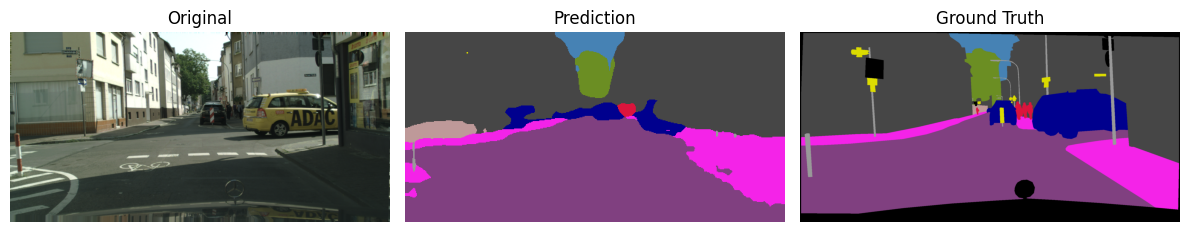

In [ ]:


# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'🟢' if torch.cuda.is_available() else '🟡'} Using: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

num_classes = 19
resize = (256, 512)
model_path = 'deeplabv3_cityscapes_best.pth'
image_path = 'datasets/realcityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png'
ground_image_path = 'datasets/realcityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'

# 🔁 Output dir con timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join('inference_outputs', f'infer_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

# 🧠 Load model
model = deeplabv3_resnet50(pretrained=False, num_classes=19).to(device)
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model'] if 'model' in checkpoint else checkpoint
# Rimuovi aux_classifier
filtered_dict = {k: v for k, v in state_dict.items() if not k.startswith('aux_classifier')}
model.load_state_dict(filtered_dict, strict=False)
model.eval()

# 🔁 Preprocessing
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])

def decode_segmap(pred):
    h, w = pred.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label in range(COLORS.shape[0]):
        color_mask[pred == label] = COLORS[label]
    return color_mask

def run_inference(image_path, ground_path=None):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        output = torch.nn.functional.interpolate(output, size=resize, mode='bilinear', align_corners=False)

        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        seg_image = decode_segmap(prediction)

    # 📸 Salvataggio immagini
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    Image.fromarray(seg_image).save(os.path.join(output_dir, f"{base_name}_pred.png"))
    image.resize(resize).save(os.path.join(output_dir, f"{base_name}_original.png"))

    if ground_path:
        gt = Image.open(ground_path)
        gt.save(os.path.join(output_dir, f"{base_name}_gt.png"))

    # 📊 Visualizzazione generale
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(seg_image)
    plt.axis('off')

    if ground_path:
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth")
        plt.imshow(gt)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{base_name}_all.png"))
    plt.show()

# 🚀 Run
run_inference(image_path, ground_image_path)
